# Read band data

In [3]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window # Untuk membaca window secara efisien

# Path ke file GeoTIFF
dem_file_path = '../DATA/LANDSAT/Thermal_RGB_Agung.tif'

# Jumlah piksel pertama yang ingin dibaca
N_PIXELS_TO_READ = 15

with rasterio.open(dem_file_path) as src:
    band_count = src.count
    
    # Langsung tentukan koordinat untuk N piksel pertama di baris pertama (baris ke-0)
    pixel_rows = np.array([0] * N_PIXELS_TO_READ)  # Semua dari baris ke-0
    pixel_cols = np.arange(N_PIXELS_TO_READ)      # Kolom 0, 1, ..., N_PIXELS_TO_READ-1
    
    # Membuat dictionary untuk menyimpan data.
    # Panggilan src.xy() akan error jika pixel_cols ada yang >= src.width.
    data = {
        'row': pixel_rows,
        'col': pixel_cols,
        'geometry': [src.xy(r_idx, c_idx) for r_idx, c_idx in zip(pixel_rows, pixel_cols)]
    }
    
    # Definisikan window untuk membaca N piksel pertama dari baris pertama.
    # Panggilan src.read() dengan window ini akan error jika N_PIXELS_TO_READ > src.width.
    read_window = Window(col_off=0, row_off=0, width=N_PIXELS_TO_READ, height=1)
    
    # Membaca setiap band hanya untuk window yang telah ditentukan.
    # Looping ini dibatasi oleh jumlah band.
    for band_idx in range(1, band_count + 1):
        band_data_subset = src.read(band_idx, window=read_window)
        # band_data_subset akan berbentuk (1, N_PIXELS_TO_READ)
        # flatten() akan mengubahnya menjadi array 1D dengan N_PIXELS_TO_READ elemen.
        data[f'band_{band_idx}'] = band_data_subset.flatten()
            
    # Membuat dataframe dari dictionary.
    # DataFrame akan memiliki N_PIXELS_TO_READ baris.
    tif_df = pd.DataFrame(data)

print(tif_df)

    row  col                                  geometry     band_1  band_2  \
0     0    0  (115.47721704793094, -8.316468153085912)  23.270258  8642.0   
1     0    1  (115.47748654251617, -8.316468153085912)  22.953924  8172.0   
2     0    2   (115.4777560371014, -8.316468153085912)  22.620281  7511.0   
3     0    3  (115.47802553168664, -8.316468153085912)  22.318615  7052.0   
4     0    4  (115.47829502627188, -8.316468153085912)  22.389990  7129.0   
5     0    5  (115.47856452085712, -8.316468153085912)  22.729780  7385.0   
6     0    6  (115.47883401544235, -8.316468153085912)  23.054918  7964.0   
7     0    7  (115.47910351002758, -8.316468153085912)  23.079472  8237.0   
8     0    8  (115.47937300461282, -8.316468153085912)  22.997608  8278.0   
9     0    9  (115.47964249919805, -8.316468153085912)  22.929344  8134.0   
10    0   10  (115.47991199378329, -8.316468153085912)  22.781754  7832.0   
11    0   11  (115.48018148836853, -8.316468153085912)  22.521641  7729.0   

# Visualize Thermal

Menampilkan cloudy.tif


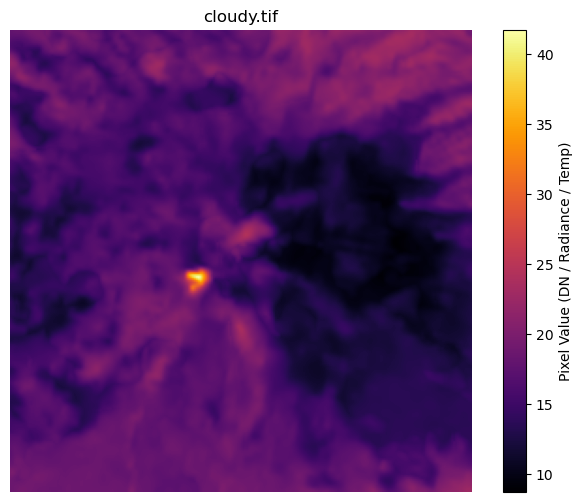

Menampilkan filtered.tif


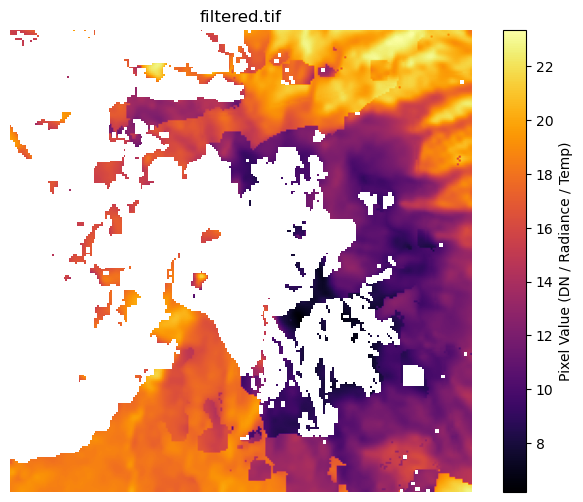

In [2]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path folder
thermal_folder_path = '../DATA/LANDSAT'

# Loop semua file .tif
for fname in os.listdir(thermal_folder_path):
    if fname.endswith('.tif'):
        fpath = os.path.join(thermal_folder_path, fname)
        print(f"Menampilkan {fname}")

        # Baca file GeoTIFF
        with rasterio.open(fpath) as src:
            img = src.read(1)  # ambil band pertama (karena thermal biasanya single band)

            # Mask nilai no data
            img = np.where(img == src.nodata, np.nan, img)

            # Tampilkan
            plt.figure(figsize=(8, 6))
            plt.imshow(img, cmap="inferno")
            plt.colorbar(label="Pixel Value (DN / Radiance / Temp)")
            plt.title(fname)
            plt.axis("off")
            plt.show()


# Viz Thermal + True Color

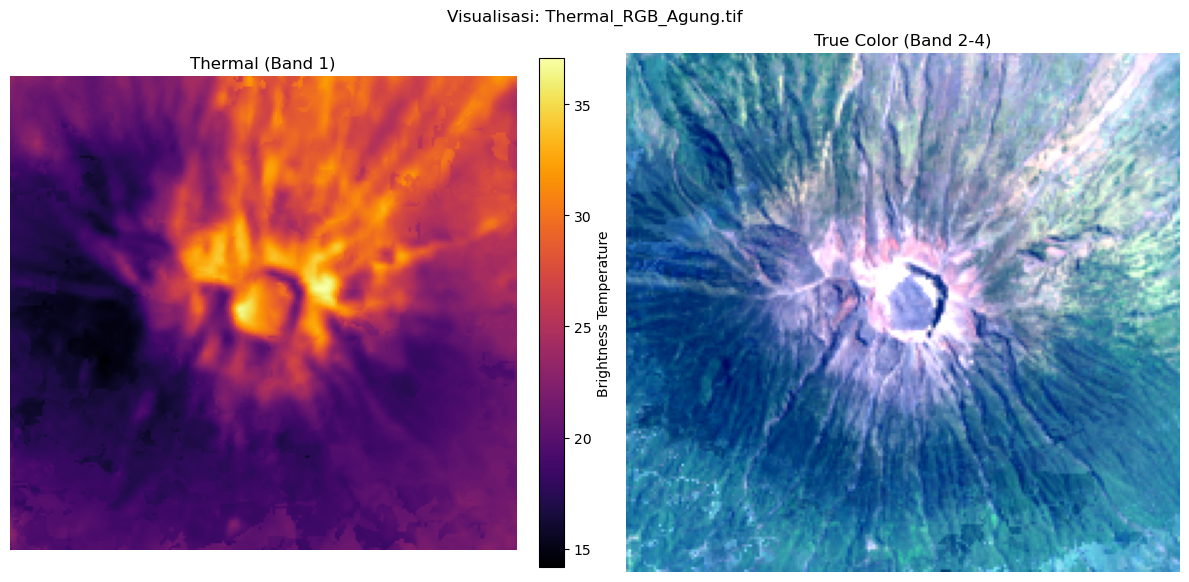

In [7]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path folder
thermal_folder_path = '../DATA/LANDSAT'

# Cari file .tif
tif_files = [f for f in os.listdir(thermal_folder_path) if f.endswith('.tif')]

for tif in tif_files:
    tif_path = os.path.join(thermal_folder_path, tif)

    with rasterio.open(tif_path) as src:
        # Asumsi band 1 = thermal, band 2-4 = RGB
        thermal = src.read(1)
        rgb = np.stack([src.read(2), src.read(3), src.read(4)], axis=-1).astype(float)

        # Normalisasi RGB ke [0,1] biar enak dilihat
        rgb_min, rgb_max = np.percentile(rgb, (2, 98))  # pakai stretch 2-98%
        rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Thermal (single band + colorbar kanan)
    im1 = axes[0].imshow(thermal, cmap="inferno")
    axes[0].set_title("Thermal (Band 1)")
    axes[0].axis("off")
    cbar = plt.colorbar(im1, ax=axes[0], orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label("Brightness Temperature")

    # True color
    axes[1].imshow(rgb)
    axes[1].set_title("True Color (Band 2-4)")
    axes[1].axis("off")

    plt.suptitle(f"Visualisasi: {tif}")
    plt.tight_layout()
    plt.show()
